In this network we train whole VGG16 network starting from frozen version (only classifier) and using preprocessed dataset. 

### Environment

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.6.4


In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Dataset

In [ ]:
data_dir = '/kaggle/input/corino-preprocessed'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3
batch_size = 32

In [ ]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

training_set = datagen.flow_from_directory(
        directory = training_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

validation_set = datagen.flow_from_directory(
        directory = validation_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


### Fine Tuning

In [ ]:
frozen_tl_model = tfk.models.load_model('/kaggle/input/vgg16frozen/kaggle/working')
frozen_tl_model.summary()

2023-02-01 07:09:22.945891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 07:09:22.946844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 07:09:22.947630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 07:09:22.948388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 07:09:22.949134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771   

In [ ]:
# Set all VGG16 layers to True
frozen_tl_model .get_layer('vgg16').trainable = True
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(frozen_tl_model.get_layer('vgg16').layers):
  layer.trainable = True
for i, layer in enumerate(frozen_tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
frozen_tl_model.summary()

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
____________

In [ ]:
finetuned_model = frozen_tl_model
finetuned_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(10**-5), metrics='accuracy')
finetuned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771   

In [ ]:
earlystopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)

# Learning Rate callback
learningrate = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-8, verbose = 1)

callbacks_list = [earlystopping, learningrate]

In [ ]:
# Train the model
history = finetuned_model.fit(
    x = training_set,
    epochs = 100,
    validation_data = validation_set,
    callbacks = callbacks_list
).history

2023-02-01 07:09:48.725602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-01 07:09:51.563707: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


339/339 [==============================] - 235s 622ms/step - loss: 0.2259 - accuracy: 0.9169 - val_loss: 0.1860 - val_accuracy: 0.9205
Epoch 2/100
339/339 [==============================] - 194s 571ms/step - loss: 0.1651 - accuracy: 0.9352 - val_loss: 0.1654 - val_accuracy: 0.9330
Epoch 3/100
339/339 [==============================] - 194s 571ms/step - loss: 0.1192 - accuracy: 0.9567 - val_loss: 0.1386 - val_accuracy: 0.9433
Epoch 4/100
339/339 [==============================] - 193s 571ms/step - loss: 0.1099 - accuracy: 0.9610 - val_loss: 0.1289 - val_accuracy: 0.9497
Epoch 5/100
339/339 [==============================] - 193s 570ms/step - loss: 0.0890 - accuracy: 0.9664 - val_loss: 0.1061 - val_accuracy: 0.9596
Epoch 6/100
339/339 [==============================] - 193s 570ms/step - loss: 0.0683 - accuracy: 0.9759 - val_loss: 0.1325 - val_accuracy: 0.9476
Epoch 7/100
339/339 [==============================] - 194s 572ms/step - loss: 0.0752 - accuracy: 0.9720 - val_loss: 0.1129 - val_

### Results

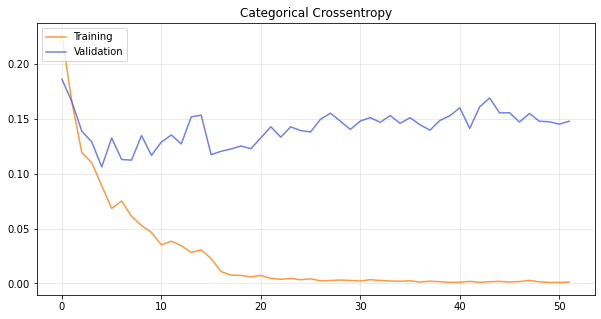

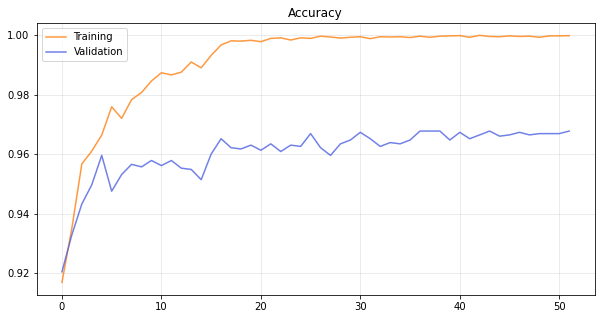

In [ ]:
# Plot the training

# loss
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

In [ ]:
finetuned_model.save('/kaggle/working')

2023-02-01 10:04:37.325243: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
!zip -r VGG16_finetuning.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/saved_model.pb (deflated 90%)
  adding: kaggle/working/variables/ (stored 0%)
  adding: kaggle/working/variables/variables.index (deflated 74%)
  adding: kaggle/working/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/assets/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


In [ ]:
from IPython.display import FileLink 
FileLink(r'VGG16_finetuning.zip')

/kaggle/working/VGG16_finetuning.zip

##### Validation

In [ ]:
finetuned_model.evaluate(validation_set)

73/73 [==============================] - 13s 169ms/step - loss: 0.1445 - accuracy: 0.9678


[0.14453907310962677, 0.9677696824073792]

In [ ]:
val_predictions = finetuned_model.predict(validation_set)
y_val = validation_set.labels

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9680    0.9796    0.9737      1420
           1     0.9857    0.9795    0.9826       635
           2     0.9228    0.8787    0.9002       272

    accuracy                         0.9678      2327
   macro avg     0.9588    0.9459    0.9522      2327
weighted avg     0.9675    0.9678    0.9676      2327



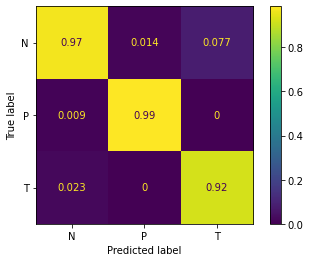

In [ ]:
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

##### Test

In [ ]:
finetuned_model.evaluate(test_set)

73/73 [==============================] - 28s 386ms/step - loss: 0.1816 - accuracy: 0.9619


[0.18159495294094086, 0.9618882536888123]

In [ ]:
val_predictions = finetuned_model.predict(test_set)

              precision    recall  f1-score   support

           0     0.9566    0.9820    0.9692      1392
           1     0.9732    0.9748    0.9740       634
           2     0.9633    0.8339    0.8939       283

    accuracy                         0.9619      2309
   macro avg     0.9644    0.9302    0.9457      2309
weighted avg     0.9620    0.9619    0.9613      2309



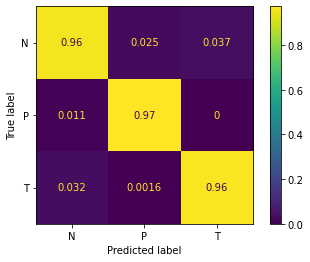

In [ ]:
y_val = test_set.labels
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))